In [1]:
from math import sqrt, exp
from copy import deepcopy

import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_figure(images: list, titles: list, rows: int, columns: int, fig_width=15, fig_height=7):
    fig = plt.figure(figsize=(fig_width, fig_height))
    count = 1
    for image, title in zip(images, titles):
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(image, 'gray')
        plt.axis('off')
        plt.title(title)

In [3]:
def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

In [4]:
def display_freq(freq):
    return 20*np.log(np.abs(freq))

In [5]:
def gaussian_lowpass(D0: int, image_shape: tuple):
    base = np.zeros(image_shape[:2])
    rows, cols = image_shape[:2]
    center = (rows/2, cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = exp((-distance((y,x),center)**2)/(2*(D0**2)))
    return base

In [6]:
def plot_historgrams(image):
    for i, col in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.title('histogram')
        plt.xlim([0, 256])

plt.show()

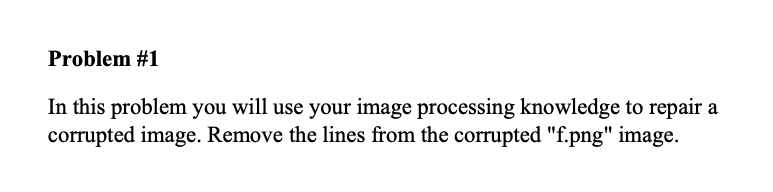

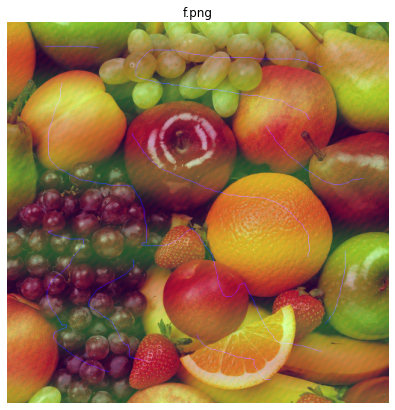

In [7]:
image_name = 'f.png'
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_figure([image], [image_name], 1, 1)

In [8]:
red_channel = image[:,:,0] # Red channel
green_channel = image[:,:,1] # Green channel
blue_channel = image[:,:,2] # Blue channel

In [9]:
fourier_transform = np.fft.fft2(red_channel)
center_shift = np.fft.fftshift(fourier_transform)

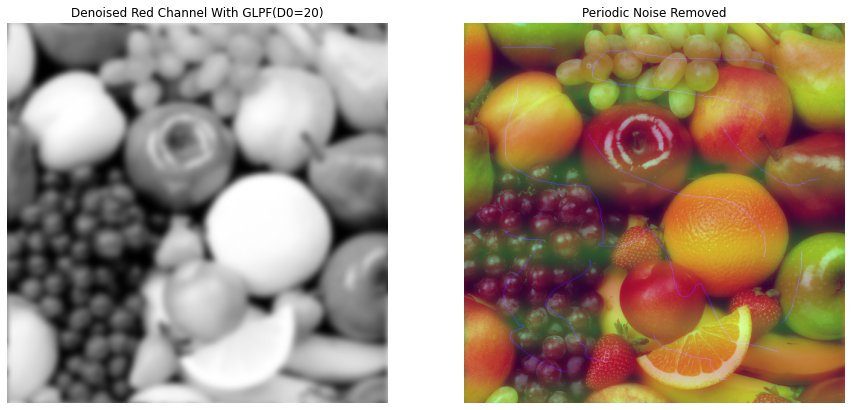

In [10]:
cutoff_frequency = 20

glpf = gaussian_lowpass(cutoff_frequency, (image.shape[0], image.shape[1]))
filtered = center_shift * glpf
ifftshift_filtered = np.fft.ifftshift(filtered)
periodic_noise_removed = abs(np.fft.ifft2(ifftshift_filtered))

image[:, :, 0] = periodic_noise_removed
plot_figure([periodic_noise_removed, image],
            [f'Denoised Red Channel With GLPF(D0={cutoff_frequency})', 'Periodic Noise Removed'], 1, 2)

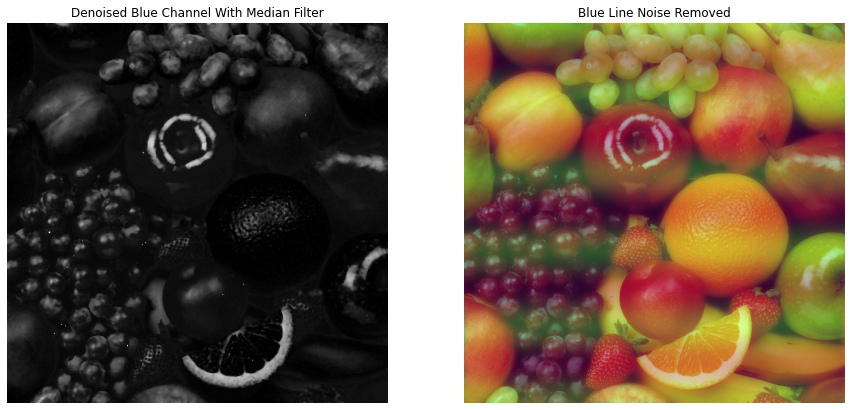

In [11]:
blue_line_removed = cv2.medianBlur(blue_channel, 3)
image[:, :, 2] = blue_line_removed

plot_figure([blue_line_removed, image],
            ['Denoised Blue Channel With Median Filter', 'Blue Line Noise Removed'], 1, 2)

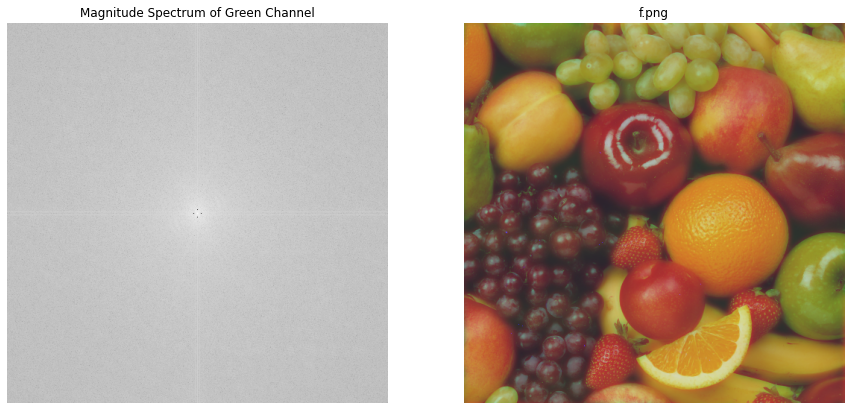

In [12]:
fourier_transform = np.fft.fft2(green_channel)
center_shift = np.fft.fftshift(fourier_transform)
center = (center_shift.shape[0]//2, center_shift.shape[1]//2)

center_shift[center[0]-5, center[1]] = 1e-10
center_shift[center[0]+5, center[1]] = 1e-10
center_shift[center[0], center[1]-5] = 1e-10
center_shift[center[0], center[1]+5] = 1e-10

magnitude_spectrum = display_freq(center_shift)

halo_removed = abs(np.fft.ifft2(center_shift))
image[:, :, 1] = halo_removed

plot_figure([magnitude_spectrum, image], [ f'Magnitude Spectrum of Green Channel', image_name], 1, 2)

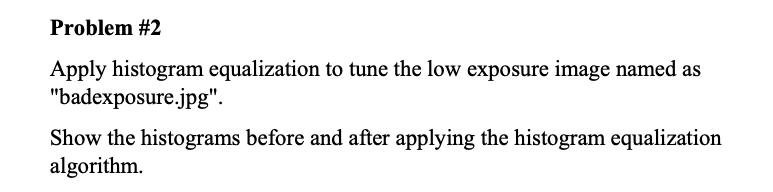

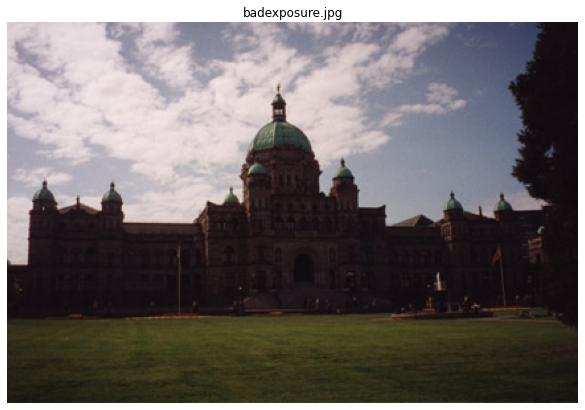

In [13]:
image_name = 'badexposure.jpg'
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plot_figure([image], [image_name], 1, 1)

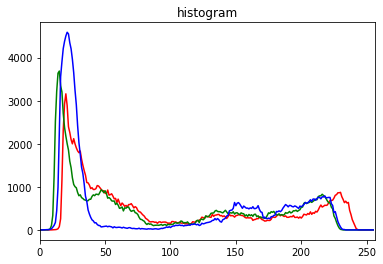

In [14]:
# before histogram equalization

plot_historgrams(image)

In [15]:
# convert rgb to hsv
hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# equalize value histogram of hsv image
hsv_img[:, :, 2] = cv2.equalizeHist(hsv_img[:, :, 2])  

# convert hsv to rgb
equalized_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)  

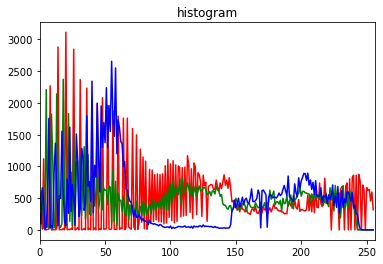

In [16]:
# after histogram equalization

plot_historgrams(equalized_img)

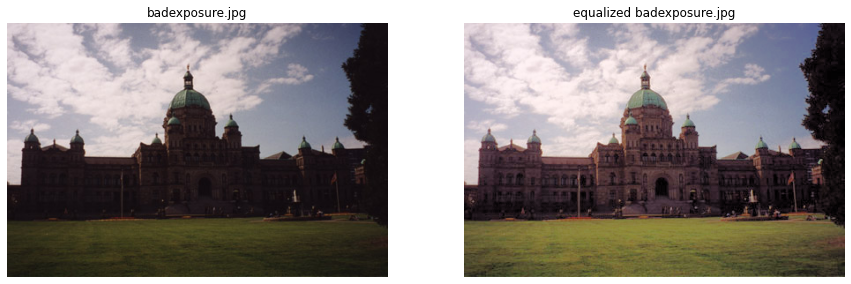

In [17]:
plot_figure([image, equalized_img], [image_name, f'equalized {image_name}'], 1, 2)

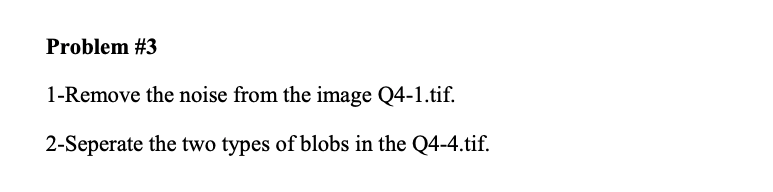

# 1.

I used **opening** for noise removal. Opening is just another name of erosion followed by dilation. It is useful in removing noise. 

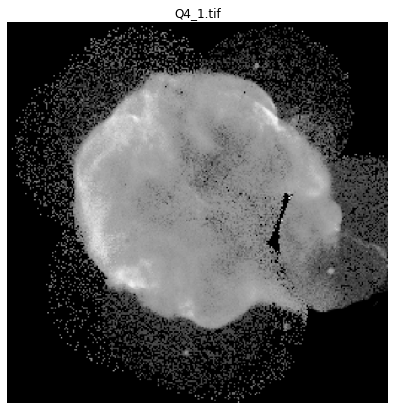

In [18]:
image_name = 'Q4_1.tif'
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plot_figure([image], [image_name], 1, 1)

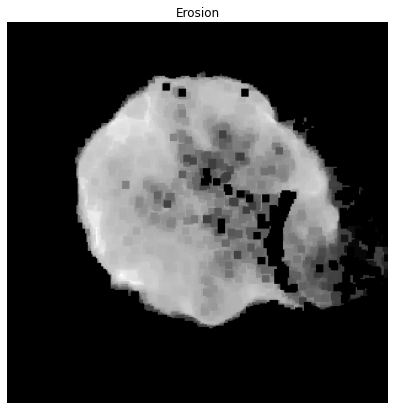

In [19]:
kernel = np.ones((10, 10))
erosion = cv2.erode(image, kernel, iterations=1)

plot_figure([erosion], [f'Erosion'], 1, 1)

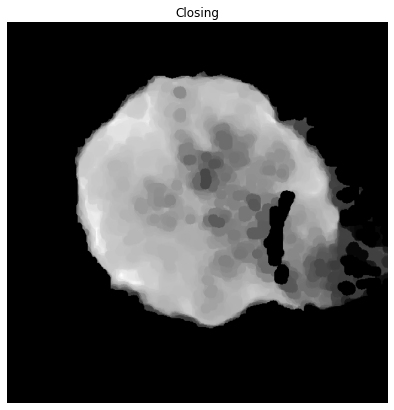

In [20]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15, 15))
closing = cv2.morphologyEx(np.array(erosion), cv2.MORPH_CLOSE, kernel)

plot_figure([closing], [f'Closing'], 1, 1)

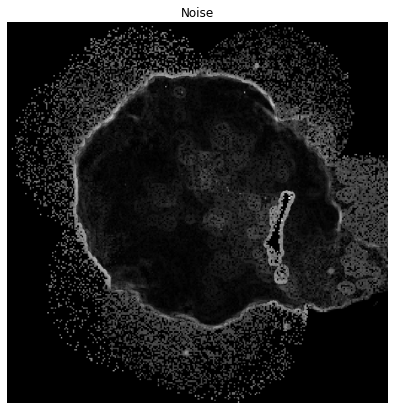

In [21]:
noises = cv2.absdiff(image, closing)
plot_figure([noises], [f'Noise'], 1, 1)

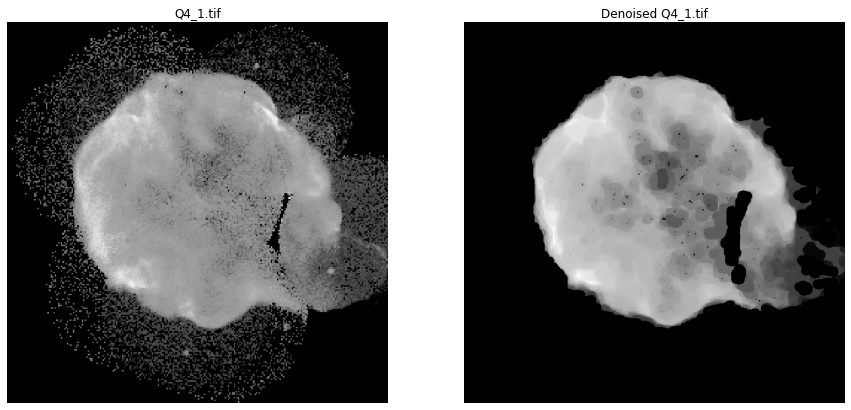

In [22]:
plot_figure([image, cv2.absdiff(image, noises)], [image_name, f'Denoised {image_name}'], 1, 2)

# 2.

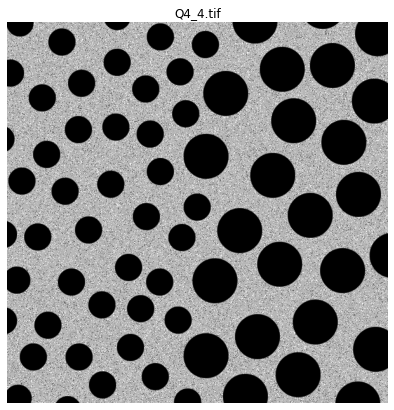

In [23]:
image_name = 'Q4_4.tif'
image = cv2.imread(image_name, 0)
plot_figure([image], [image_name], 1, 1)

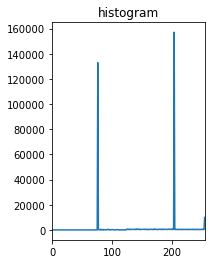

In [24]:
plt.subplot(1,2,2)
hist,bin = np.histogram(image.ravel(), 256, [0,255])
plt.xlim([0,255])
plt.plot(hist)
plt.title('histogram')

plt.show()

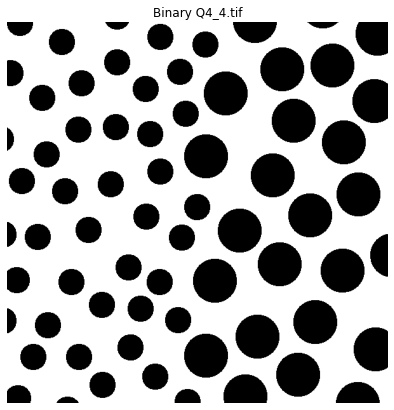

In [25]:
image[image<=76] = 0
image[image>76] = 255

plot_figure([image], [f'Binary {image_name}'], 1, 1)

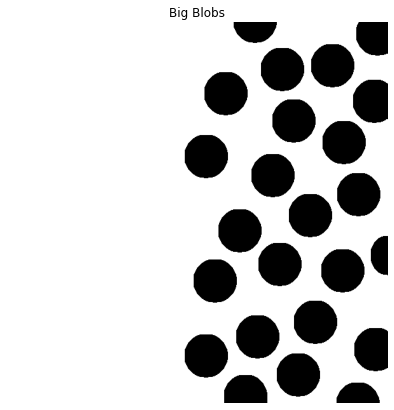

In [26]:
# big circles

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50, 50))
erosion = cv2.dilate(np.array(image), kernel, iterations=1)
img = cv2.erode(erosion, kernel, iterations=1)

plot_figure([img], ['Big Blobs'], 1, 1)

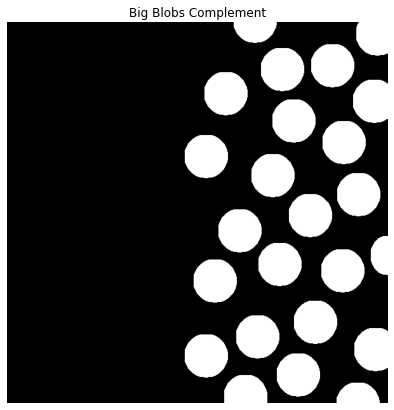

In [27]:
inverted = np.abs(img - 255)

plot_figure([inverted], ['Big Blobs Complement'], 1, 1)

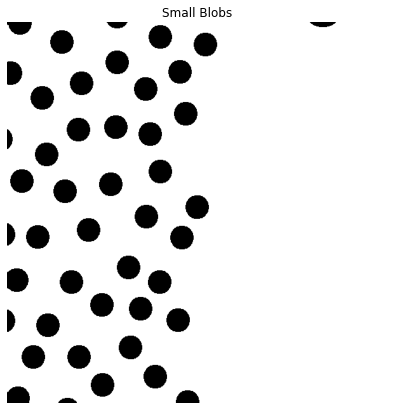

In [28]:
# little circles

img = image - inverted
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
img = cv2.dilate(img, kernel, iterations=1)

plot_figure([img], ['Small Blobs'], 1, 1)

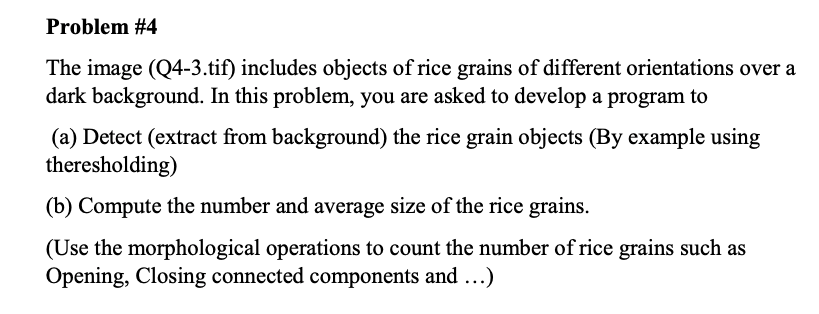

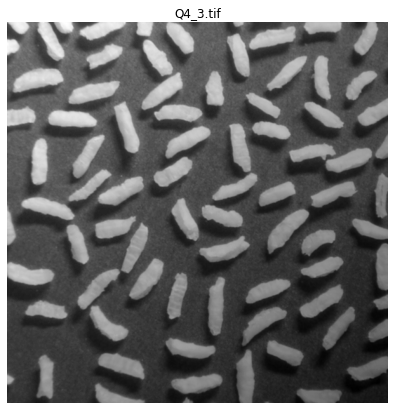

In [29]:
image_name = 'Q4_3.tif'
image = cv2.imread(image_name, 0)
plot_figure([image], [image_name], 1, 1)

## a.

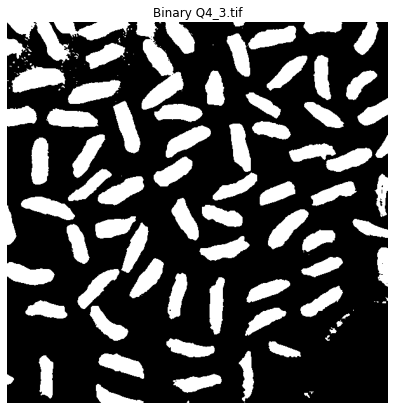

In [30]:
binr = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plot_figure([binr], [f'Binary {image_name}'], 1, 1)

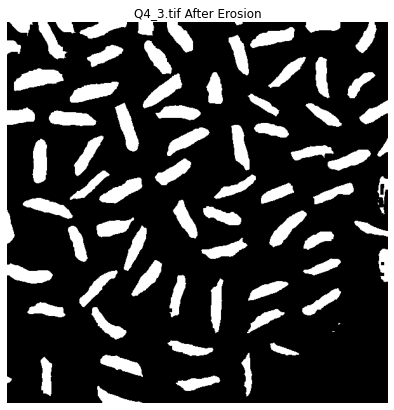

In [31]:
kernel = np.ones((5, 5),np.uint8)

output_erosion = cv2.erode(binr, kernel, iterations=1)

plot_figure([output_erosion], [f'{image_name} After Erosion'], 1, 1)

# b.

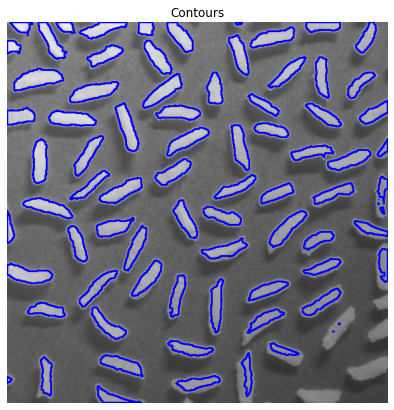

In [32]:
contours, hierarchy = cv2.findContours(output_erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output_contour = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(output_contour, contours, -1, (0, 0, 255), 2)

plot_figure([output_contour], ['Contours'], 1, 1)

In [33]:
area_sum = 0

for contour in contours:
    area_sum += cv2.contourArea(contour)

print("Number of detected contours", len(contours))
print(f"Average Area of Rice Grains: {area_sum/len(contours):.3f}")

Number of detected contours 79
Average Area of Rice Grains: 800.051
